In [1]:
import os
import pandas as pd
import numpy as np
import random
import gc
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.feature_extraction.text import TfidfVectorizer
from  collections import Counter

np.random.seed(2019)
random.seed(2019)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 280)
pd.set_option('display.max_colwidth', 150)
data_path = '/data/workspace/kimi/tencent_ads/2020/dataset'
preprocess_path = 'preprocess'

In [2]:
clk_df = pd.read_csv(f'{data_path}/train_preliminary/click_log.csv' )
clk_test_df = pd.read_csv(f'{data_path}/test/click_log.csv' )
clk_df = pd.concat([clk_df,clk_test_df],axis=0)
print(clk_df)


          time  user_id  creative_id  click_times
0            9    30920       567330            1
1           65    30920      3072255            1
2           56    30920      2361327            1
3            6   309204       325532            1
4           59   309204      2746730            1
...        ...      ...          ...          ...
33585507    16  3131989       585914            1
33585508    13  3131989       749134            1
33585509    12  3131989       589027            1
33585510    61  3131989      2404831            1
33585511    14  3131989       665822            1

[63668283 rows x 4 columns]


1900000
3648518    113974
3834944     26609
3093561     25506
3206914     18178
839368      16868
3522917     11116
3548147     10318
3038145      2295
3094381      2108
3066940      2064
Name: user_id, dtype: int64
773026     9
3349831    9
278200     9
677060     9
3946806    9
          ..
3807588    9
3853772    9
3013416    9
59951      9
3122069    9
Name: user_id, Length: 1000, dtype: int64
589192     10
3429569    10
3534670    10
441608     10
382026     10
           ..
639004     10
3099251    10
3797556    10
698481     10
862337     10
Name: user_id, Length: 10000, dtype: int64
483853     15
3334857    15
332009     15
3596320    15
85395      15
           ..
3111794    14
3473810    14
3714847    14
3620391    14
3025307    14
Name: user_id, Length: 100000, dtype: int64
3417072    44
3363780    44
182752     44
711447     44
392665     44
           ..
867303     39
518881     39
80412      39
631005     39
3799058    39
Name: user_id, Length: 100000, dtype: int64
p[0.1]

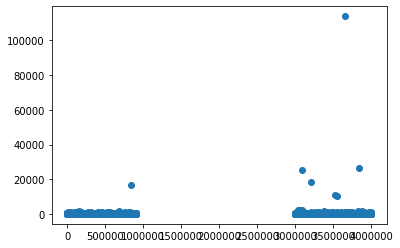

In [3]:
adv_count_value= clk_df['user_id'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
print(adv_count_value[-10000:-9000])
print(adv_count_value[-50000:-40000])
print(adv_count_value[-500000:-400000])
print(adv_count_value[-1500000:-1400000])
for v in [(i+1)*0.1 for i in range(10)] + [ (i+1)*0.01 + 0.9 for i in range(9)] + [ (i+1)*0.001 + 0.99 for i in range(9)]:
    q = adv_count_value.quantile(v)
    print(f'p[{round(v,3)}]:{q}')
#adv_count_value = adv_count_value[adv_count_value.values < 200]

#null_counts = adv_count_value['\\N']
#print(f"null:{null_counts}")
x = adv_count_value.index
y = adv_count_value.values
arr = np.array(adv_count_value.values)
print(len(arr))
print(np.mean(arr))
print(np.median(arr))
print(np.std(arr))

plt.scatter(x,y)
plt.show()


91
85    885349
78    860217
84    834380
64    822412
57    809818
74    805973
63    795623
91    795028
34    789308
36    787226
Name: time, dtype: int64
Int64Index([85, 78, 84, 64, 57, 74, 63, 91, 34, 36, 31, 77, 73, 43, 35, 75, 65, 37, 32, 71, 33, 56, 79, 67, 50, 70, 88, 49, 90, 66, 81, 82, 83, 72, 14, 68, 86, 76, 80, 55, 60, 54, 69, 87, 42, 58, 53, 61, 45, 52, 46, 22, 59, 48, 40, 30, 89, 47, 41, 51, 62, 15, 29, 44, 13, 21, 39,
            18, 28, 38,  1, 17, 26,  8, 19, 16, 25, 11, 27, 23,  7, 24,  2, 12, 10, 20,  3,  4,  5,  9,  6],
           dtype='int64')


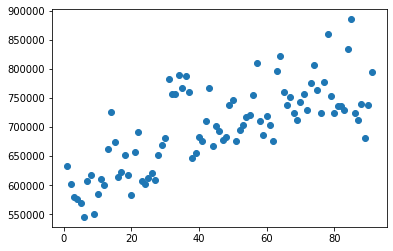

In [4]:
adv_count_value= clk_df['time'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
#null_counts = adv_count_value['\\N']
#print(f"null:{null_counts}")
x = adv_count_value.index
print(x)
y = adv_count_value.values
plt.scatter(x,y)
plt.show()

         user_id  click_times_total
384504    384505                 10
953168   3053169                 10
953110   3053111                 10
1616483  3716484                 10
1616485  3716486                 10
...          ...                ...
839367    839368              21330
1106913  3206914              23328
993560   3093561              33372
1734943  3834944              35283
1548517  3648518             194614

[1900000 rows x 2 columns]


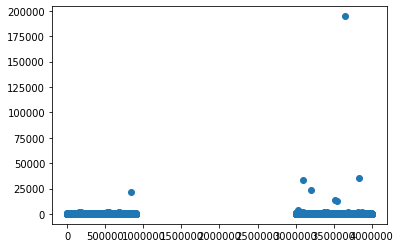

In [5]:
user_click_sum_df = clk_df.groupby(['user_id']).click_times.sum().reset_index().rename(columns={'click_times':'click_times_total'}).sort_values(by='click_times_total')
print(user_click_sum_df)
x = user_click_sum_df['user_id'].values.tolist()
y = user_click_sum_df['click_times_total'].values.tolist()
plt.scatter(x,y)
plt.show()

In [7]:
ad_df = pd.read_csv(f'{data_path}/train_preliminary/ad.csv' )

In [8]:
merged_df = clk_df.merge(ad_df,on='creative_id')
merged_df.replace("\\N",-1,inplace=True)
merged_df.fillna(-1).astype(float)
merged_df['wday'] = merged_df['time'].apply(lambda x :int(x /7))
merged_df['month'] = merged_df['time'].apply(lambda x :int(x /30))
print(merged_df)

MemoryError: 